# GCN-TFT vs GCN-NBEATS for Traffic Forecasting
This notebook trains and compares two graph-based models:
- **GCN-TFT**: Combines graph convolutions with a transformer-style attention block
- **GCN-NBEATS**: Combines graph convolutions with a residual fully-connected architecture (N-BEATS)

It also plots RMSE and MAE over training epochs.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Using: cuda
GPU: NVIDIA RTX A4000


In [2]:
data = np.load("pems08.npz")
graph_signal = data["data"]

# Interpolate missing
for sensor in range(graph_signal.shape[1]):
    for feature in range(graph_signal.shape[2]):
        series = pd.Series(graph_signal[:, sensor, feature])
        graph_signal[:, sensor, feature] = series.interpolate(method="linear", limit_direction="both")

mean = graph_signal.mean(axis=0)
graph_signal_centered = graph_signal - mean


In [3]:
distance_df = pd.read_csv("distance.csv")
num_nodes = 170
adj_matrix = np.zeros((num_nodes, num_nodes))

for _, row in distance_df.iterrows():
    i, j, dist = int(row['from']), int(row['to']), float(row['cost'])
    if dist >= 3.5:
        adj_matrix[i, j] = 1 / dist

adj_matrix = np.maximum(adj_matrix, adj_matrix.T)
adj_tensor = torch.tensor(adj_matrix, dtype=torch.float32)
degree = torch.sum(adj_tensor, dim=1)
deg_inv_sqrt = torch.pow(degree, -0.5)
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0.0
D_inv_sqrt = torch.diag(deg_inv_sqrt)
adj_tensor = D_inv_sqrt @ adj_tensor @ D_inv_sqrt
adj_tensor = adj_tensor.to(device)


In [4]:
def create_dataset(data, num_his=12, num_pred=12):
    X, Y = [], []
    for t in range(len(data) - num_his - num_pred):
        X.append(data[t:t+num_his])
        Y.append(data[t+num_his:t+num_his+num_pred])
    return np.array(X), np.array(Y)

points_per_day = 288
train_data = graph_signal_centered[:288*50]
test_data = graph_signal_centered[288*50:288*62]

X_train, Y_train = create_dataset(train_data)
X_test, Y_test = create_dataset(test_data)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_t, Y_train_t), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, Y_test_t), batch_size=64, shuffle=False)


In [5]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
    def forward(self, x, adj):
        return F.relu(self.linear(torch.matmul(adj, x)))

class SimpleTFTBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        self.linear = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
    def forward(self, x):
        x = self.linear(x)
        attn_out, _ = self.attn(x, x, x)
        out, _ = self.gru(attn_out)
        return out

class GCN_TFT(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.gcn = GCNLayer(3, hidden_dim)
        self.tft = SimpleTFTBlock(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 12)
    def forward(self, x, adj):
        B, T, N, F = x.shape
        x = x.view(B*T, N, F)
        x = self.gcn(x, adj)
        x = x.view(B, T, N, -1).permute(0,2,1,3).reshape(B*N, T, -1)
        x = self.tft(x)
        x = self.output(x[:, -1, :])
        return x.view(B, N, -1).permute(0,2,1).unsqueeze(-1)

class NBEATSBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.fc(x)

class GCN_NBEATS(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.gcn = GCNLayer(3, hidden_dim)
        self.nbeats = NBEATSBlock(12 * hidden_dim, hidden_dim, 12)
    def forward(self, x, adj):
        B, T, N, F = x.shape
        x = x.view(B*T, N, F)
        x = self.gcn(x, adj)
        x = x.view(B, T, N, -1).permute(0,2,1,3).reshape(B*N, T * x.shape[-1])
        x = self.nbeats(x)
        return x.view(B, N, -1).permute(0,2,1).unsqueeze(-1)


In [6]:
def train_one_epoch(model, loader, optimizer, criterion, adj):
    model.train()
    total = 0
    for X, Y in loader:
        X, Y = X.to(device), Y[..., 0:1].to(device)
        optimizer.zero_grad()
        Y_hat = model(X, adj)
        loss = criterion(Y_hat, Y)
        loss.backward()
        optimizer.step()
        total += loss.item()
    return total / len(loader)

def evaluate(model, loader, adj):
    model.eval()
    total_rmse, total_mae, count = 0, 0, 0
    with torch.no_grad():
        for X, Y in loader:
            X, Y = X.to(device), Y[..., 0:1].to(device)
            Y_hat = model(X, adj).reshape_as(Y)
            rmse = torch.sqrt(torch.mean((Y_hat - Y) ** 2))
            mae = torch.mean(torch.abs(Y_hat - Y))
            total_rmse += rmse.item() * X.size(0)
            total_mae += mae.item() * X.size(0)
            count += X.size(0)
    return total_rmse / count, total_mae / count


In [7]:
models = {
    "GCN_TFT": GCN_TFT().to(device),
    "GCN_NBEATS": GCN_NBEATS().to(device)
}

histories = {}

for name, model in models.items():
    print(f"\nTraining {name}")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    rmses, maes = [], []

    for epoch in range(10):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, adj_tensor)
        rmse, mae = evaluate(model, test_loader, adj_tensor)
        rmses.append(rmse)
        maes.append(mae)
        print(f"{name} | Epoch {epoch+1}: Train Loss={train_loss:.2f}, RMSE={rmse:.2f}, MAE={mae:.2f}")

    histories[name] = {"RMSE": rmses, "MAE": maes}



Training GCN_TFT
GCN_TFT | Epoch 1: Train Loss=10247.29, RMSE=90.02, MAE=71.06
GCN_TFT | Epoch 2: Train Loss=7784.31, RMSE=81.47, MAE=63.67
GCN_TFT | Epoch 3: Train Loss=6543.12, RMSE=75.04, MAE=58.37
GCN_TFT | Epoch 4: Train Loss=5753.78, RMSE=71.58, MAE=55.51
GCN_TFT | Epoch 5: Train Loss=5278.06, RMSE=69.17, MAE=53.75
GCN_TFT | Epoch 6: Train Loss=4996.84, RMSE=67.62, MAE=52.49
GCN_TFT | Epoch 7: Train Loss=4760.54, RMSE=66.10, MAE=51.29
GCN_TFT | Epoch 8: Train Loss=4636.21, RMSE=65.53, MAE=50.87
GCN_TFT | Epoch 9: Train Loss=4493.30, RMSE=64.48, MAE=50.07
GCN_TFT | Epoch 10: Train Loss=4370.84, RMSE=63.64, MAE=49.41

Training GCN_NBEATS
GCN_NBEATS | Epoch 1: Train Loss=5322.04, RMSE=68.49, MAE=53.03
GCN_NBEATS | Epoch 2: Train Loss=4723.40, RMSE=65.85, MAE=51.18
GCN_NBEATS | Epoch 3: Train Loss=4428.80, RMSE=63.67, MAE=49.79
GCN_NBEATS | Epoch 4: Train Loss=4313.50, RMSE=63.36, MAE=49.83
GCN_NBEATS | Epoch 5: Train Loss=4253.23, RMSE=63.03, MAE=49.11
GCN_NBEATS | Epoch 6: Train L

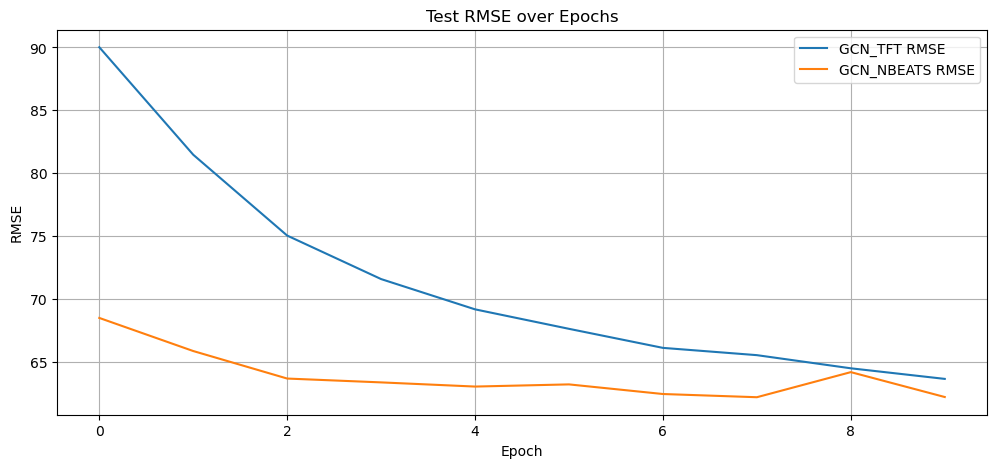

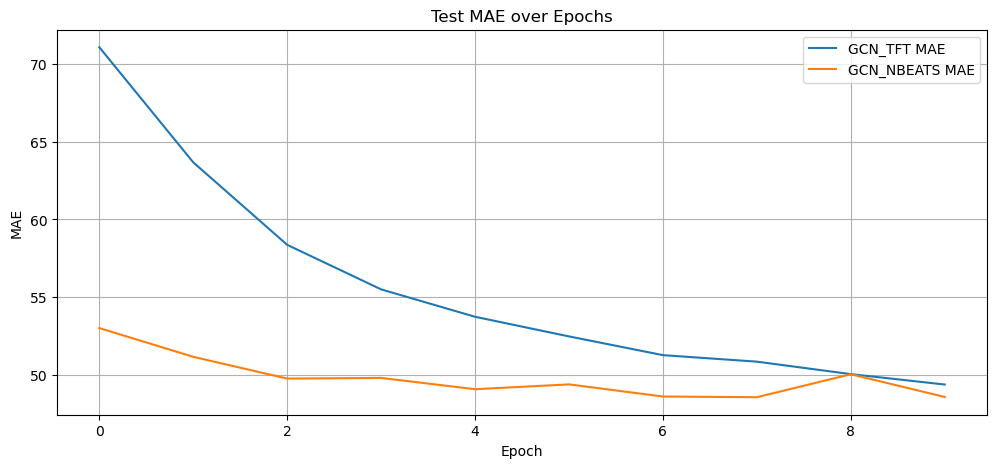

In [8]:
plt.figure(figsize=(12, 5))

for name in histories:
    plt.plot(histories[name]["RMSE"], label=f"{name} RMSE")

plt.title("Test RMSE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
for name in histories:
    plt.plot(histories[name]["MAE"], label=f"{name} MAE")

plt.title("Test MAE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()
plt.show()